How many entries were made per day?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Make a dataframe showing only whether meals were successfully recorded, and remove nearby ones

"""
import pandas as pd
from itertools import islice

from ema import clean

# Read data in
meal_df = clean.cleaned_smartwatch(keep_catchups=False)

# Collapse meal type to positive/negative response
assert set(meal_df["meal_type"].unique()) == {
    "Meal",
    "Drink",
    "Snack",
    "No food/drink",
    "No response",
}, set(meal_df["meal_type"].unique())
meal_df["pos_entry"] = meal_df["meal_type"].isin({"Meal", "Drink", "Snack", "No Food"})

# Column for day of the study
meal_df["day"] = meal_df["delta"].dt.days

# Use multiindex
meal_df.set_index(["p_id", meal_df.index], inplace=True)

# Remove duplicates
meal_df = meal_df[~meal_df.index.duplicated(keep="first")]

# Set index back
meal_df.reset_index(inplace=True)
meal_df.set_index("Datetime", inplace=True)

n_rows = len(meal_df)
meal_df["keep"] = True
for _, group in meal_df.groupby("p_id"):
    for (prev_time, prev_row), (next_time, next_row) in zip(
        islice(group.iterrows(), n_rows - 1), islice(group.iterrows(), 1, n_rows)
    ):
        # If this is the within 2min of the previous entry and they are both True, mark the later ones to remove
        if (
            next_time - prev_time < pd.Timedelta(minutes=2)
            and prev_row["pos_entry"]
            and next_row["pos_entry"]
        ):
            meal_df.loc[next_time, "keep"] = False

# Remove also No responses at 8am since these are probably missed catchups
meal_df.loc[
    ((meal_df["pos_entry"] == False) & (meal_df.index.hour == 8)), "keep"
] = False

meal_df = meal_df[meal_df["keep"]]
meal_df.drop(columns=["keep"], inplace=True)

/home/mh19137/seaco_malaysia/ema/clean.py:189: UserWarning: Long catchup: not marking Meal at 2022-05-19 09:02:49 as catchup
  warnings.warn(


 Open ended catchup at 2022-02-11 20:02:05 ended by No response at 2022-02-12 08:02:11
 Open ended catchup at 2022-02-14 20:26:30 ended by No response at 2022-02-15 08:02:16
 Open ended catchup at 2022-04-19 08:01:14 ended by No catch-up at 2022-04-19 08:01:17
 Open ended catchup at 2022-06-27 15:53:14 ended by Catch-up start at 2022-06-27 15:54:06
 Open ended catchup at 2021-12-31 22:11:10 ended by No catch-up at 2022-01-01 08:01:15
 Open ended catchup at 2022-05-24 07:25:36 ended by Catch-up start at 2022-05-24 07:26:00
 Open ended catchup at 2022-03-21 08:01:57 ended by No catch-up at 2022-03-21 08:02:04
 Open ended catchup at 2022-03-07 18:33:30 ended by No catch-up at 2022-03-07 18:33:34
 Open ended catchup at 2022-03-07 18:37:08 ended by No catch-up at 2022-03-07 18:37:14
 Open ended catchup at 2022-03-07 19:29:23 ended by No response at 2022-03-08 08:02:56
 Open ended catchup at 2022-03-08 08:30:40 ended by No catch-up at 2022-03-08 08:31:08
 Open ended catchup at 2022-03-08 09:

In [3]:
"""
Find how many entries were made per day

"""
import numpy as np

pos_entries_per_day = []
neg_entries_per_day = []
total_entries_per_day = []
pos_days = []
neg_days = []
total_days = []
for (_, day), group in meal_df.groupby(["p_id", "day"]):

    value_counts = group["pos_entry"].value_counts()
    try:
        pos_entries_per_day.append(value_counts[True])
        pos_days.append(day)
    except KeyError:
        ...

    try:
        neg_entries_per_day.append(value_counts[False])
        neg_days.append(day)
    except KeyError:
        ...
    
    total_entries_per_day.append(len(group))
    total_days.append(day)
    

pos_entries_per_day = np.array(pos_entries_per_day)
neg_entries_per_day = np.array(neg_entries_per_day)
pos_days = np.array(pos_days)
neg_days = np.array(neg_days)
total_entries_per_day = np.array(total_entries_per_day)
total_days = np.array(total_days)

In [22]:
"""
Find the mean compliance rate

"""
n_participants = len(meal_df["p_id"].unique())
n_days = len(meal_df["day"].unique())

expected_per_day = 12
expected = expected_per_day * n_days * n_participants
actual = total_entries_per_day.sum()

fraction = actual / expected

print(f"Fraction {100 * fraction:.2f}%")


print((total_entries_per_day > 12).sum() / n_days / n_participants)
print((total_entries_per_day < 12).sum() / n_days / n_participants)
print((total_entries_per_day == 12).sum() / n_days / n_participants)

Fraction 85.69%
0.11703958691910499
0.04819277108433735
0.6919104991394148


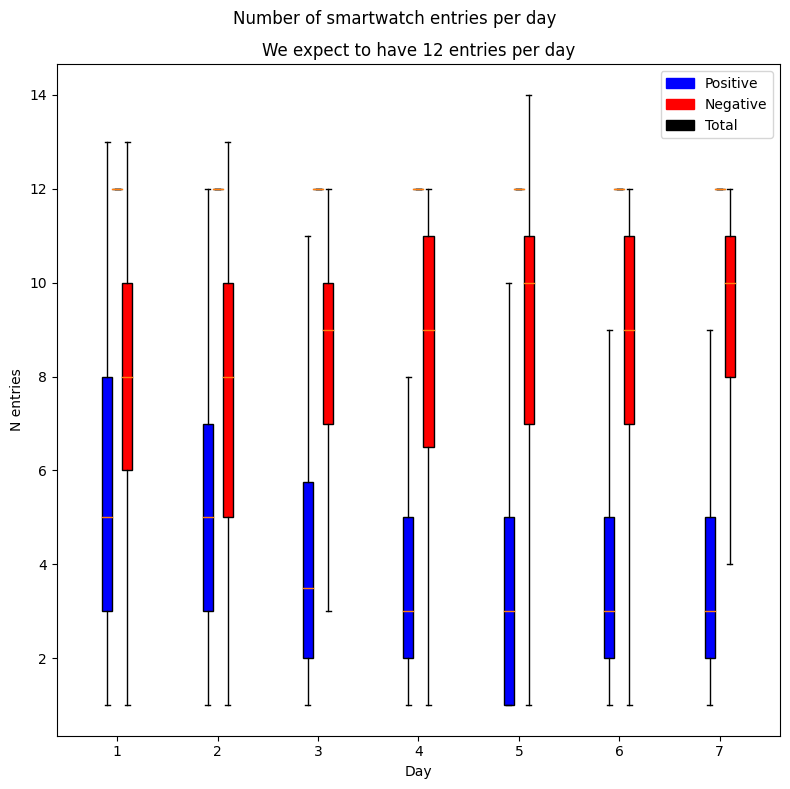

In [11]:
"""
Boxplot of how many positive/negative/total entries were made per day

"""

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, axis = plt.subplots(figsize=(8, 8))

box_kw = {"widths": 0.1, "showfliers": False, "patch_artist": True}
days = np.arange(1, 8)

for day in days:
    pos_box = axis.boxplot(
        pos_entries_per_day[pos_days == day],
        positions=[day - box_kw["widths"]],
        **box_kw,
    )
    for box in pos_box["boxes"]:
        box.set_facecolor("b")

    neg_box = axis.boxplot(
        neg_entries_per_day[neg_days == day],
        positions=[day + box_kw["widths"]],
        **box_kw,
    )
    for box in neg_box["boxes"]:
        box.set_facecolor("r")

    total_box = axis.boxplot(
        total_entries_per_day[total_days == day], positions=[day], **box_kw
    )
    for box in total_box["boxes"]:
        box.set_facecolor("k")

axis.set_xticks(days, days)

axis.set_xlabel("Day")
axis.set_ylabel("N entries")

axis.legend(
    [Patch(color="b"), Patch(color="r"), Patch(color="k")],
    ["Positive", "Negative", "Total"],
    loc="upper right",
)

fig.suptitle("Number of smartwatch entries per day")
axis.set_title("We expect to have 12 entries per day")

fig.tight_layout()

fig.savefig("img/entries_per_day_boxplot.png")